<h1>Imports</h1>

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

set_config(display='diagram')
plt.style.use('seaborn')

<h1>Load the dataset</h1>

For this benchmark, we will use the `House Prices - Advanced Regression Techniques` dataset available <a href="https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques">here</a>.

In [3]:
DIRECTORY_ROOT = '.'
DATASETS_PATH = Path().joinpath('datasets', 'house-prices-advanced-regression-techniques')

def load_housing_data(datasets_path=DATASETS_PATH):
    csv_path = datasets_path.joinpath('train.csv')
    return pd.read_csv(csv_path)

train_set = load_housing_data()
X = train_set.drop('SalePrice', axis=1)
y = train_set['SalePrice'].copy()

X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


<h1>Preprocess</h1>

In [4]:
cat_cols = list(X.select_dtypes('object').columns)
num_cols = list(X.select_dtypes(np.number).columns)

num_pipe = Pipeline([
    ('num_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehotencode', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('num_pipe', num_pipe, num_cols),
    ('cat_pipe', cat_pipe, cat_cols)
])

X_tr = preprocessor.fit_transform(X)

preprocessor

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['Id', 'MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFin...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'Neighborhood', 'Condition1',
                                  'Condition2', 'BldgType', 'HouseStyle',
                                  'RoofStyle', 'RoofMatl', 'Exterior1st',
                                  'Exterior2nd', 'MasVnrType', 'ExterQual',
                                  'ExterCond', 'Foundation', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', ...])])

<h1>Define our evaluation benchmark</h1>

In [5]:
cv = ShuffleSplit(n_splits=5, test_size=0.2)

def bench_regressor(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=['r2', 'neg_root_mean_squared_error']
    )
    r2 = cv_results['test_r2'].mean()
    rmse = -cv_results['test_neg_root_mean_squared_error'].mean()
    fit_time = cv_results['fit_time'].mean()
    name = model.__class__.__name__
    
    return [name, fit_time, rmse, r2]

<h1>Run the benchmark</h1>

In [6]:
estimators = [
    LinearRegression(),
    DecisionTreeRegressor(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
]

results = []

for estimator in estimators:
    model_results = bench_regressor(estimator, X_tr, y, cv=cv)
    results.append(model_results)

<h1>Visualize the results</h1>

In [7]:
def plot_benchmark_results():
    
    df = pd.DataFrame(results, columns=['name', 'fit_time', 'rmse', 'r2'])
    
    fig, ax = plt.subplots(1, 3, figsize=(13,3), sharey=True)

    ax[0].grid()
    bars = ax[0].barh(df.name, df.fit_time, color='r', alpha=0.6)
    ax[0].set_title('fit time (s)')
    for bar in bars:
        width = bar.get_width()
        ax[0].text(
            width/2,
            bar.get_y() + bar.get_height()/2,
            f'{round(width, 1)}s',
            fontsize=11
        )

    ax[1].grid()
    bars = ax[1].barh(df.name, df.rmse, color='g', alpha=0.6)
    ax[1].set_title('RMSE')
    for bar in bars:
        width = bar.get_width()
        ax[1].text(
            width/2,
            bar.get_y() + bar.get_height()/2,
            f'{int(width)}',
            fontsize=11
        )

    ax[2].grid()
    bars = ax[2].barh(df.name, df.r2, alpha=0.6)
    ax[2].set_title('$R^2$')
    for bar in bars:
        width = bar.get_width()
        ax[2].text(
            width/2,
            bar.get_y() + bar.get_height()/2,
            f'{round(width, 1)}',
            fontsize=11
        )

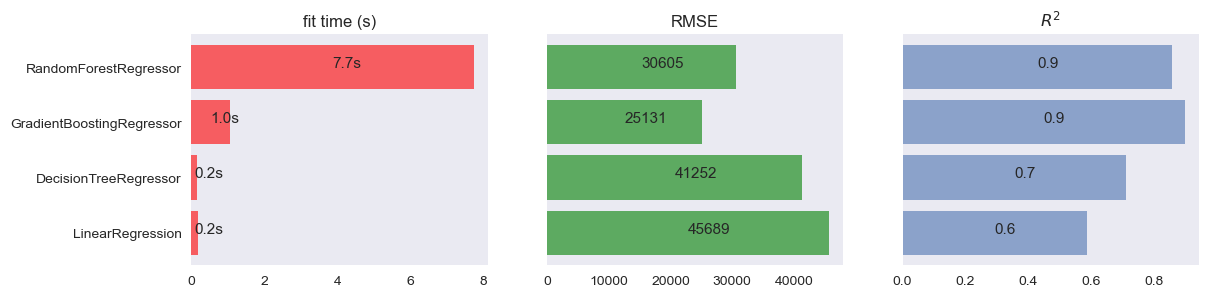

In [8]:
plot_benchmark_results()